# Waste Classification using Trashnet Dataset

Data set : https://github.com/garythung/trashnet


---







### Import module

In [55]:
import os
import zipfile
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from numpy import random
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Define path dataset

In [91]:
base_path = "/content/drive/Shareddrives/capstone-project-c22-ps085/ML/dataset/trashnet_data"
dataset_path = os.path.join(base_path, 'data', 'dataset-resized')
os.listdir(dataset_path)

['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']

## Delete unnecessary hidden files

In [58]:
import glob
import shutil

def delete(path):
    if os.path.isfile(path) or os.path.islink(path):
        os.remove(path)
    elif os.path.isdir(path):
        shutil.rmtree(path)
    print('deleted: ' + path)

n = 0
for root, subdir, file in os.walk(dataset_path):
    pattern = os.path.join(root, '.*')
    for path in (glob.glob(pattern)):
        n += 1
        # print(path)
        delete(path)
print(f'{n} hidden file or folder found')

deleted: /content/drive/Shareddrives/capstone-project-c22-ps085/ML/dataset/trashnet_data/data/dataset-resized/.vscode
deleted: /content/drive/Shareddrives/capstone-project-c22-ps085/ML/dataset/trashnet_data/data/dataset-resized/trash/.gitignore
2 hidden file or folder found


## Check image detail

In [59]:
# classname
class_image = os.listdir(dataset_path)
class_image

['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']

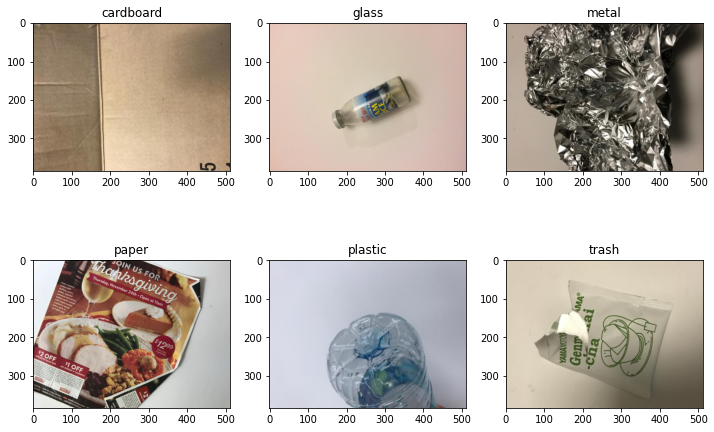

In [60]:
def get_random_data_perclass():
    random_data_perclass = []

    for root, _, files in os.walk(dataset_path):
        # skip check folder in data_resized
        if len(files) == 0: 
            continue
        random_index = random.randint(0, len(files) - 1)
        rand_data_path = os.path.join(root,  files[random_index])
        random_data_perclass.append(rand_data_path)
    return random_data_perclass

# subplot dimension
nrows = 2
ncols = 3

# Index for iterating over images
pic_index = 0
fig = plt.gcf()
fig.set_size_inches(ncols * 4, nrows * 4)

random_data = get_random_data_perclass()
for i, img_path in enumerate(random_data):
# Set up subplot; subplot indices start at 1
    sp = plt.subplot(nrows, ncols, i + 1)
    sp.axis('On')
    img = mpimg.imread(img_path)
    plt.imshow(img)
    plt.title(class_image[i])


In [84]:
def get_all_image_path():
    data = []
    for root, dirs, files in os.walk(dataset_path):
        # skip check folder in data_resized
        if len(files) == 0:
            continue
        for file in files:
            img_path = os.path.join(root, file)
            data.append(img_path)
    return data

In [85]:
# image description
n_data = len(get_all_image_path())
print("Number of image data: " + str(n_data))

image = mpimg.imread(random_data[random.randint(0, 6)])
print(f"Image height: {image.shape[0]}")
print(f"Image width: {image.shape[1]}")
print(f"Image channel: {image.ndim}")

Number of image data: 2527
Image height: 384
Image width: 512
Image channel: 3


## Load image

### define some image parameter

In [87]:
BATCH_SIZE = 120
IMG_HEIGHT = 180
IMG_WIDTH = 180

### load image as tf.dataset

In [88]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    dataset_path,
    shuffle=True,
    validation_split=0.2,
    subset="training",
    seed=123,
    label_mode = 'categorical',
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    dataset_path,
    shuffle=True,
    validation_split=0.2,
    subset="validation",
    seed=123,
    label_mode = 'categorical',
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE
)

Found 2527 files belonging to 6 classes.
Using 2022 files for training.
Found 2527 files belonging to 6 classes.
Using 505 files for validation.


In [89]:
class_names = train_ds.class_names
print(class_names)

['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']


### show sample image from tf.dataset

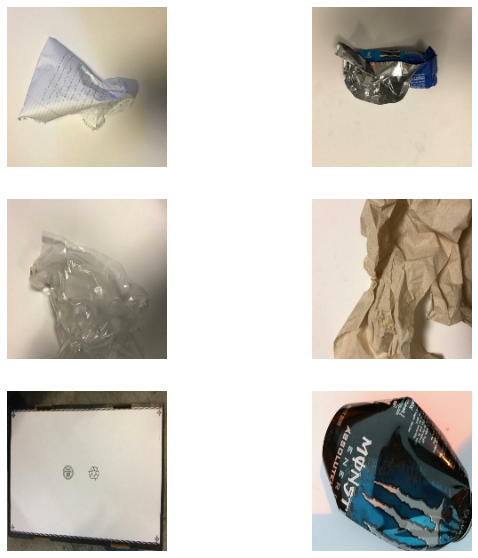

In [90]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(6):
    ax = plt.subplot(3, 2, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    # plt.title(class_names[labels[i]])
    plt.axis("off")

## Image Augmentaion and Modeling

In [93]:
# augmentastion
IMG_SIZE = (180, 180)

resize_and_rescale = tf.keras.Sequential([
    tf.keras.layers.Resizing(IMG_SIZE[0], IMG_SIZE[1]),
    tf.keras.layers.Rescaling(1./255.)
])

data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip("horizontal_and_vertical"),
  tf.keras.layers.RandomRotation((-0.3,0.3)),
  tf.keras.layers.RandomZoom((-0.2,0.1)),
  tf.keras.layers.RandomTranslation(0.1,0.1)
])

### self model

In [ ]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Input(shape=(180, 180, 3)),

    resize_and_rescale,         
    data_augmentation,

    tf.keras.layers.Conv2D(16, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),

    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Dropout(0.2),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(6, activation='softmax')
])

### Transfer learning

In [ ]:
base_model = tf.keras.applications.Xception(include_top=False, 
                                            weights = 'imagenet', 
                                            input_shape = (img_height, img_width,3))
base_model.trainable = False

83697664/83683744 [==============================] - 0s 0us/step


In [ ]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Input(shape=(180, 180, 3)),

    resize_and_rescale,
    data_augmentation,
    base_model,

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(6, activation='softmax')
])

In [ ]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 180, 180, 3)       0         
                                                                 
 sequential_1 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 xception (Functional)       (None, 6, 6, 2048)        20861480  
                                                                 
 flatten (Flatten)           (None, 73728)             0         
                                                                 
 dense (Dense)               (None, 32)                2359328   
                                                                 
 dense_1 (Dense)             (None, 6)                 198       
                                                                 
Total params: 23,221,006
Trainable params: 2,359,526
N

In [ ]:
model.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(learning_rate=(0.001)),
              metrics=['accuracy'])

### Training

In [ ]:
ACCURACY_THRESHOLD = 0.95
class myCallback(tf.keras.callbacks.Callback): 
    def on_epoch_end(self, epoch, logs={}): 
        if(logs.get('accuracy') > ACCURACY_THRESHOLD):   
            print("\nReached %2.2f%% accuracy, so stopping training!!" %(ACCURACY_THRESHOLD*100))   
            self.model.stop_training = True

In [ ]:
callbacks = myCallback()
history = model.fit(train_ds,
                    validation_data=val_ds,
                    epochs=200,
                    callbacks=callbacks,
                    verbose=1)

Epoch 1/200
17/17 [==============================] - 505s 29s/step - loss: 2.2644 - accuracy: 0.5049 - val_loss: 1.0354 - val_accuracy: 0.6376
Epoch 2/200
17/17 [==============================] - 11s 525ms/step - loss: 0.9095 - accuracy: 0.6954 - val_loss: 0.8485 - val_accuracy: 0.7208
Epoch 3/200
17/17 [==============================] - 11s 528ms/step - loss: 0.7448 - accuracy: 0.7517 - val_loss: 0.7789 - val_accuracy: 0.7426
Epoch 4/200
17/17 [==============================] - 11s 532ms/step - loss: 0.6624 - accuracy: 0.7784 - val_loss: 0.7225 - val_accuracy: 0.7743
Epoch 5/200
17/17 [==============================] - 11s 537ms/step - loss: 0.6361 - accuracy: 0.7789 - val_loss: 0.7188 - val_accuracy: 0.7802
Epoch 6/200
17/17 [==============================] - 11s 541ms/step - loss: 0.5840 - accuracy: 0.7814 - val_loss: 0.6775 - val_accuracy: 0.7644
Epoch 7/200
17/17 [==============================] - 11s 545ms/step - loss: 0.5856 - accuracy: 0.7888 - val_loss: 0.8315 - val_accuracy: 

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


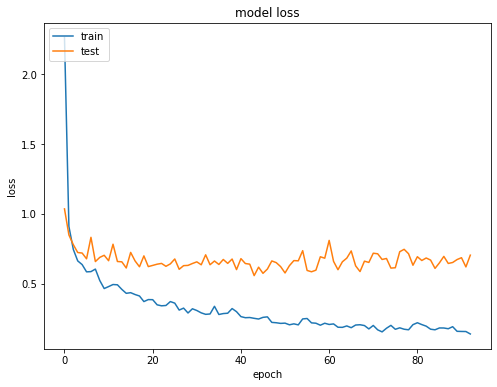

In [ ]:
print(history.history.keys())

# import matplotlib.pylab as plt
from matplotlib.pyplot import figure
figure(figsize=(8, 6))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

### Save model

In [ ]:
import datetime
now = datetime.datetime.now()
time = now.strftime("%Y-%m-%d_%H:%M:%S")

In [ ]:
!mkdir -p $base_path/saved_model/$time
path = os.path.join(base_path, 'saved_model', time)
pathh5 = os.path.join(base_path, 'modelh5')

In [ ]:
model.save( os.path.join(pathh5, f'trashnet_{time}-xception-(180,180)-augmented-preprocessing.h5'))

### try with new data

Saving plastic4.jpeg to plastic4.jpeg
[3.6513939e-04 3.0075435e-02 3.4151408e-06 2.1433149e-02 9.3945146e-01
 8.6713536e-03]
plastic with a 93.95 percent confidence.


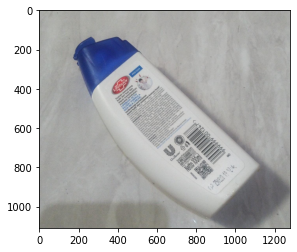

In [ ]:
class_names = train_ds.class_names

import numpy as np

from google.colab import files
from keras.preprocessing import image

uploaded = files.upload()

for fn in uploaded.keys():
    img_path = os.path.join('/content', fn)

    img = tf.keras.utils.load_img(
        img_path, target_size=(IMG_HEIGHT, IMG_WIDTH)
    )
    img_array = tf.keras.utils.img_to_array(img)
    
    img = mpimg.imread(img_path)
    plt.imshow(img)
    
    img_array = tf.expand_dims(img_array, 0) # Create a batch
    predictions = model.predict(img_array)
    print(predictions[0])

    print(f"{class_names[np.argmax(predictions[0])]} with a {100 * np.max(predictions[0]):.2f} percent confidence.")